<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#COMPAS-data" data-toc-modified-id="COMPAS-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>COMPAS data</a></span></li><li><span><a href="#Synthetic-data" data-toc-modified-id="Synthetic-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Synthetic data</a></span></li></ul></li><li><span><a href="#Algorithms" data-toc-modified-id="Algorithms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Algorithms</a></span><ul class="toc-item"><li><span><a href="#Contraction-algorithm" data-toc-modified-id="Contraction-algorithm-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Contraction algorithm</a></span></li><li><span><a href="#Causal-model" data-toc-modified-id="Causal-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Causal model</a></span></li></ul></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance comparison</a></span><ul class="toc-item"><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Predictive models</a></span></li><li><span><a href="#Causal-model" data-toc-modified-id="Causal-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Causal model</a></span></li><li><span><a href="#Visual-comparison" data-toc-modified-id="Visual-comparison-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Visual comparison</a></span></li></ul></li></ul></div>

# Bachelors thesis' analyses

*This Jupyter notebook is for the analyses and model building for Riku Laine's bachelors thesis*

Table of contents is provided above. First I will briefly present the COMPAS data set and then create the synthetic data set as done by Lakkaraju *et al.* ([link](https://helka.finna.fi/PrimoRecord/pci.acm3098066)). Then I will proceed to implement their and our algorithms. Finally I will do the side-by-side comparisons of  the  results.

## Data

### COMPAS data

The following data filtering procedure follows the one described in the [ProPublica methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as scs
import seaborn as sns
import numpy.random as npr

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (14, 7)})

# Read file
compas_raw = pd.read_csv("../data/compas-scores-two-years.csv")

# Check dimensions, number of rows should be 7214
print(compas_raw.shape)

(7214, 53)


In [2]:
# Select columns
compas = compas_raw[[
    'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
    'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',
    'two_year_recid', 'c_jail_in', 'c_jail_out'
]]

# Subset values
compas = compas.query('days_b_screening_arrest <= 30 and \
                      days_b_screening_arrest >= -30 and \
                      is_recid != -1 and \
                      c_charge_degree != "O"')

# Drop row if score_text is na
compas = compas[compas.score_text.notnull()]

compas.shape

(6172, 13)

In [3]:
out = pd.to_datetime(compas.c_jail_out, format="%Y-%m-%d %H:%M:%S")
in_ = pd.to_datetime(compas.c_jail_in, format="%Y-%m-%d %H:%M:%S")

compas['length_of_stay'] = (out - in_).astype('timedelta64[D]')

# Structure of the data
display(compas.head(5).T)

0                    1  \
age                                       69                   34   
c_charge_degree                            F                    F   
race                                   Other     African-American   
age_cat                      Greater than 45              25 - 45   
score_text                               Low                  Low   
sex                                     Male                 Male   
priors_count                               0                    0   
days_b_screening_arrest                   -1                   -1   
decile_score                               1                    3   
is_recid                                   0                    1   
two_year_recid                             0                    1   
c_jail_in                2013-08-13 06:03:42  2013-01-26 03:45:27   
c_jail_out               2013-08-14 05:41:20  2013-02-05 05:36:53   
length_of_stay                             0                   10   

                                           2                    5  \
age                                       24                   44   
c_charge_degree                            F                    M   
race                        African-American                Other   
age_cat                         Less than 25              25 - 45   
score_text                               Low                  Low   
sex                                     Male                 Male   
priors_count                               4                    0   
days_b_screening_arrest                   -1                    0   
decile_score                               4                    1   
is_recid                                   1                    0   
two_year_recid                             1                    0   
c_jail_in                2013-04-13 04:58:34  2013-11-30 04:50:18   
c_jail_out               2013-04-14 07:02:04  2013-12-01 12:28:56   
length_of_stay                             1                    1   

                                           6  
age                                       41  
c_charge_degree                            F  
race                               Caucasian  
age_cat                              25 - 45  
score_text                            Medium  
sex                                     Male  
priors_count                              14  
days_b_screening_arrest                   -1  
decile_score                               6  
is_recid                                   1  
two_year_recid                             1  
c_jail_in                2014-02-18 05:08:24  
c_jail_out               2014-02-24 12:18:30  
length_of_stay                             6

In [4]:
compas.describe(include='all').T

count unique                  top  freq      mean  \
age                      6172    NaN                  NaN   NaN   34.5345   
c_charge_degree          6172      2                    F  3970       NaN   
race                     6172      6     African-American  3175       NaN   
age_cat                  6172      3              25 - 45  3532       NaN   
score_text               6172      3                  Low  3421       NaN   
sex                      6172      2                 Male  4997       NaN   
priors_count             6172    NaN                  NaN   NaN   3.24644   
days_b_screening_arrest  6172    NaN                  NaN   NaN  -1.74028   
decile_score             6172    NaN                  NaN   NaN    4.4185   
is_recid                 6172    NaN                  NaN   NaN  0.484446   
two_year_recid           6172    NaN                  NaN   NaN   0.45512   
c_jail_in                6172   6172  2013-03-09 10:28:41     1       NaN   
c_jail_out               6172   6161  2013-09-14 05:58:00     3       NaN   
length_of_stay           6172    NaN                  NaN   NaN   14.6228   

                              std  min  25%  50%  75%  max  
age                       11.7309   18   25   31   42   96  
c_charge_degree               NaN  NaN  NaN  NaN  NaN  NaN  
race                          NaN  NaN  NaN  NaN  NaN  NaN  
age_cat                       NaN  NaN  NaN  NaN  NaN  NaN  
score_text                    NaN  NaN  NaN  NaN  NaN  NaN  
sex                           NaN  NaN  NaN  NaN  NaN  NaN  
priors_count              4.74377    0    0    1    4   38  
days_b_screening_arrest   5.08471  -30   -1   -1   -1   30  
decile_score              2.83946    1    2    4    7   10  
is_recid                 0.499799    0    0    0    1    1  
two_year_recid           0.498022    0    0    0    1    1  
c_jail_in                     NaN  NaN  NaN  NaN  NaN  NaN  
c_jail_out                    NaN  NaN  NaN  NaN  NaN  NaN  
length_of_stay            46.6935   -1    0    1    5  799

**Notes:**

* Mean age is roughly 34.5 years ranging from 18 to 96
* Defendants have an average of 3.2 priors (sd 4.7) and more than half have 1 or more prior.
* 48.4% have recidivated (or 45.5%?)

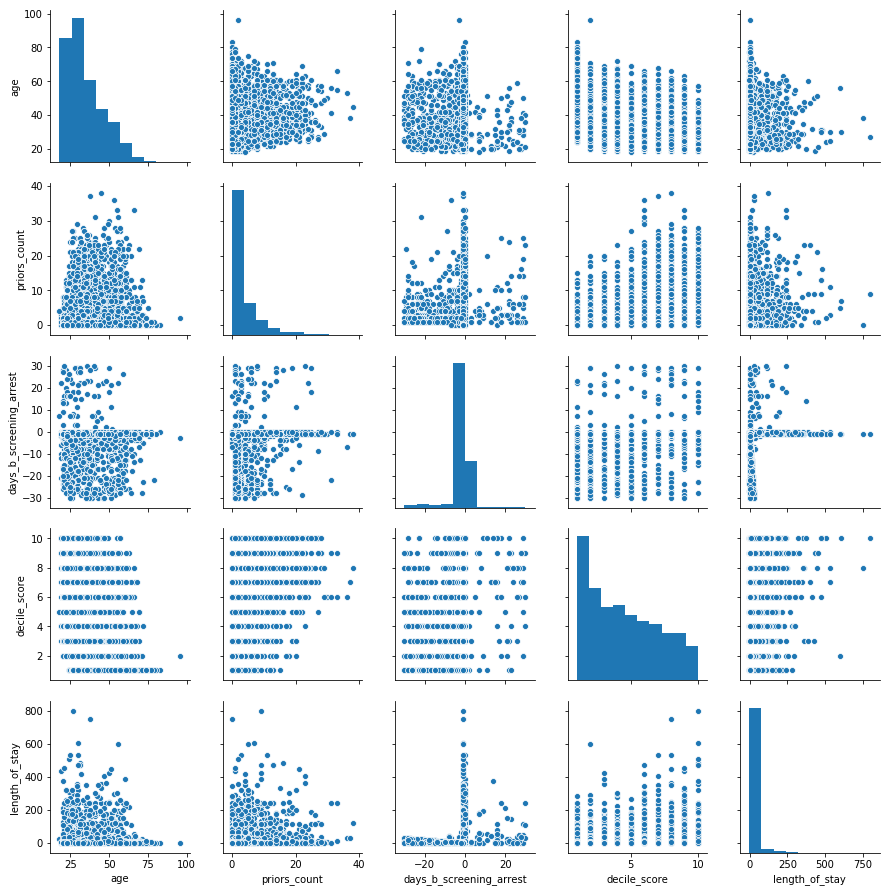

In [5]:
sns.pairplot(compas[[
    'age', 'priors_count', 'days_b_screening_arrest', 'decile_score',
    'length_of_stay'
]])
plt.show()

In [6]:
# Correlation should be 0.2073297, but R uses n-1
# as denominator in variance. Reference:
# https://stackoverflow.com/questions/53404367/why-pearson-correlation-is-different-between-tensorflow-and-scipy
print(compas[['length_of_stay', 'decile_score']].corr())

                length_of_stay  decile_score
length_of_stay        1.000000      0.207478
decile_score          0.207478      1.000000


In [7]:
# Decile scores should be evenly distributed but are not.
print(compas.decile_score.value_counts())

1     1286
2      822
4      666
3      647
5      582
6      529
7      496
9      420
8      420
10     304
Name: decile_score, dtype: int64


In [8]:
print(compas.age_cat.value_counts())

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64


In [9]:
print(compas.race.value_counts())

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64


A very small number of Asian and Native American defendants.

In [10]:
print("Black defendants: %.2f%%" % (3175 / 6172 * 100))
print("White defendants: %.2f%%" % (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" % (509 / 6172 * 100))
print("Asian defendants: %.2f%%" % (31 / 6172 * 100))
print("Native American defendants: %.2f%%" % (11 / 6172 * 100))
print("---")
print("Defendants of other ethnicity: %.2f%%" % (343 / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%
---
Defendants of other ethnicity: 5.56%


In [11]:
compas.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [12]:
tab = compas.groupby(['sex', 'race']).size()
tab.unstack()

race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285

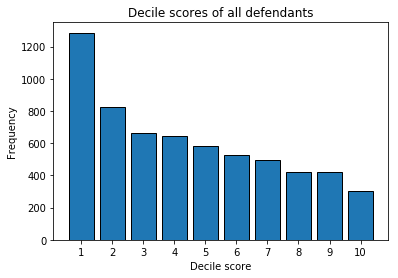

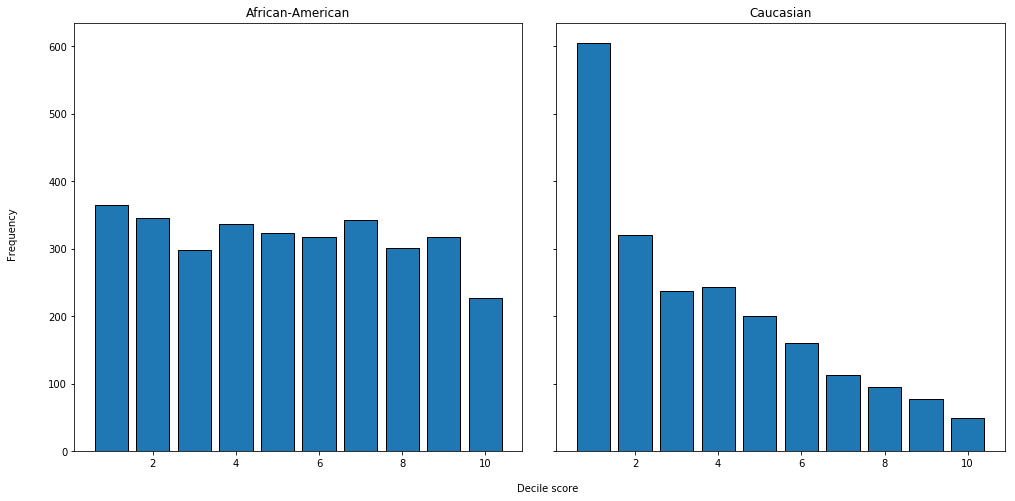

In [13]:
plt.bar(range(1, 11), compas.decile_score.value_counts(), ec='black')
plt.title("Decile scores of all defendants")
plt.ylabel("Frequency")
plt.xlabel("Decile score")
plt.xticks(range(1, 11))
plt.show()

fig, ax = compas.query("race in ['Caucasian', 'African-American']").hist(
    "decile_score",
    by="race",
    figsize=(14, 7),
    sharey=True,
    xrot='horizontal',
    ec='black',
    bins=np.arange(0.5, 11.5, 1.0),
    rwidth=0.8)

fig.text(-1.5, 350, "Frequency", rotation='vertical')
fig.text(11.5, -60, "Decile score", horizontalalignment='center')
plt.tight_layout(w_pad=-2)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


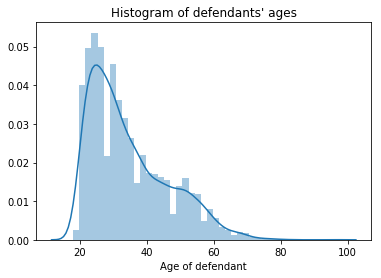

In [14]:
sns.distplot(compas.age)
plt.title("Histogram of defendants' ages")
plt.xlabel("Age of defendant")
plt.show()

In [15]:
tab = compas.groupby(['age_cat', 'is_recid']).size()
display(tab.unstack())

tab = compas.groupby(['sex', 'is_recid']).size()
display(tab.unstack())

tab = compas.groupby(['race', 'age_cat', 'is_recid']).size()
display(tab.unstack())

is_recid            0     1
age_cat                    
25 - 45          1784  1748
Greater than 45   847   446
Less than 25      551   796

is_recid     0     1
sex                 
Female     740   435
Male      2442  2555

is_recid                              0       1
race             age_cat                       
African-American 25 - 45          847.0  1051.0
                 Greater than 45  261.0   207.0
                 Less than 25     294.0   515.0
Asian            25 - 45           10.0     4.0
                 Greater than 45    7.0     4.0
                 Less than 25       4.0     2.0
Caucasian        25 - 45          620.0   508.0
                 Greater than 45  442.0   186.0
                 Less than 25     167.0   180.0
Hispanic         25 - 45          180.0   111.0
                 Greater than 45   81.0    28.0
                 Less than 25      51.0    58.0
Native American  25 - 45            5.0     2.0
                 Greater than 45    NaN     2.0
                 Less than 25       NaN     2.0
Other            25 - 45          122.0    72.0
                 Greater than 45   56.0    19.0
                 Less than 25      35.0    39.0

From above it is clear that there are no Native American recidivists of age over 45 or under 25. There are some other value combinations that might be problematic.

### Synthetic data

In the chunk below, we generate the synthetic data as described by Lakkaraju et al. The default values are as per their description. The definitions of $Y$ and $T$ values follow their description.

**Parameters**

* M = `nJudges_M`, number of judges
* N = `nSubjects_N`, number of subjects assigned to each judge
* betas $\beta_i$ = `beta_i`, where $i \in \{X, Z, W\}$ are coefficients for the respected variables
* R = `acceptanceRate_R`, acceptance rates
* X = `X`, invidual's features observable to all (models and judges)
* Z = `Z`, information observable for judges only
* W = `W`, unobservable / inaccessible information
* T = `decision_T`, decisions where $T=0$ represents decision to deny and if $T=1$ then bail is granted.
* Y = `result_Y`, result variable, if $Y=0$ person will or would recidivate and if $Y=1$ person would not commit a crime.

In [16]:
# Set seed for reproducibility
npr.seed(0)


def generateData(nJudges_M=100,
                 nSubjects_N=500,
                 beta_X=1.0,
                 beta_Z=1.0,
                 beta_W=0.2):

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    judgeID_J = np.repeat(np.arange(0, nJudges_M, dtype=np.int32), nSubjects_N)

    # Sample acceptance rates uniformly from a closed interval
    # from 0.1 to 0.9 and round to tenth decimal place.
    acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

    # Replicate the rates so they can be attached to the corresponding judge ID.
    acceptanceRate_R = np.repeat(acceptance_rates, nSubjects_N)

    # Sample the variables from standard Gaussian distributions.
    X = npr.normal(size=nJudges_M * nSubjects_N)
    Z = npr.normal(size=nJudges_M * nSubjects_N)
    W = npr.normal(size=nJudges_M * nSubjects_N)

    probabilities_Y = 1 / (1 + np.exp(-(beta_X * X + beta_Z * Z + beta_W * W)))

    # 0 if P(Y = 0| X = x; Z = z; W = w) >= 0.5 , 1 otherwise
    result_Y = 1 - probabilities_Y.round()

    probabilities_T = 1 / (1 + np.exp(-(beta_X * X + beta_Z * Z)))
    probabilities_T += npr.normal(0, .1, nJudges_M * nSubjects_N)

    # Initialize decision values as 1
    decision_T = np.ones(nJudges_M * nSubjects_N)

    # Initialize the dataframe
    df_init = pd.DataFrame(
        np.column_stack((judgeID_J, acceptanceRate_R, X, Z, W, result_Y,
                         probabilities_T, decision_T)),
        columns=[
            "judgeID_J", "acceptanceRate_R", "X", "Z", "W", "result_Y",
            "probabilities_T", "decision_T"
        ])

    # Sort by judges then probabilities
    data = df_init.sort_values(
        by=["judgeID_J", "probabilities_T"], ascending=False)

    # Iterate over the data. Subject is in the top (1-r)*100% if
    # his within-judge-index is over acceptance threshold times
    # the number of subjects assigned to each judge. If subject
    # is over the limit they are assigned a zero, else one.
    data.reset_index(drop=True, inplace=True)

    data['decision_T'] = np.where(
        (data.index.values % nSubjects_N) <
        ((1 - data['acceptanceRate_R']) * nSubjects_N), 0, 1)

    return data


df = []
df = generateData()

# Basic stats of the created data set.
display(df.describe().T)

print(df.decision_T.value_counts())

tab = df.groupby(['result_Y', 'decision_T']).size()
display(tab.unstack())

count       mean        std       min        25%  \
judgeID_J         50000.0  49.500000  28.866359  0.000000  24.750000   
acceptanceRate_R  50000.0   0.478235   0.230644  0.103756   0.264643   
X                 50000.0  -0.003875   0.996715 -4.659953  -0.671782   
Z                 50000.0   0.006964   0.998001 -4.852118  -0.666258   
W                 50000.0   0.010863   0.996944 -4.029138  -0.666574   
result_Y          50000.0   0.496500   0.499993  0.000000   0.000000   
probabilities_T   50000.0   0.500794   0.279762 -0.335627   0.276723   
decision_T        50000.0   0.477260   0.499488  0.000000   0.000000   

                        50%        75%        max  
judgeID_J         49.500000  74.250000  99.000000  
acceptanceRate_R   0.473985   0.647587   0.890699  
X                 -0.001726   0.668077   3.831790  
Z                  0.004730   0.679477   4.241772  
W                  0.012306   0.679578   4.285856  
result_Y           0.000000   1.000000   1.000000  
probabilities_T    0.501317   0.723352   1.295719  
decision_T         0.000000   1.000000   1.000000

0    26137
1    23863
Name: decision_T, dtype: int64


decision_T      0      1
result_Y                
0.0         20083   5092
1.0          6054  18771

In [17]:
# Split the data set to test and train
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.5, random_state=0)

print(train.shape)
print(test.shape)

train_labeled = train[train.decision_T == 1]
test_labeled = test[test.decision_T == 1]

print(train_labeled.shape)
print(test_labeled.shape)

tab = train_labeled.groupby(['result_Y', 'decision_T']).size()
tab.unstack()

(25000, 8)
(25000, 8)
(11866, 8)
(11997, 8)


decision_T     1
result_Y        
0.0         2495
1.0         9371

## Algorithms

### Contraction algorithm

Below is an implementation of Lakkaraju's team's algorithm presented in [their paper](https://helka.finna.fi/PrimoRecord/pci.acm3098066). Relevant parameters to be passed to the function are presented in the description.

In [18]:
def contraction(df,
                judgeIDJ_col,
                decisionT_col,
                resultY_col,
                modelProbS_col,
                accRateR_col,
                r,
                binning=False):
    '''
    This is an implementation of the algorithm presented by Lakkaraju
    et al. in their paper "The Selective Labels Problem: Evaluating 
    Algorithmic Predictions in the Presence of Unobservables" (2017).
    
    Parameters:
    df = The (Pandas) data frame containing the data, judge decisions,
    judge IDs, results and probability scores.
    judgeIDJ_col = String, the name of the column containing the judges' IDs
    in df.
    decisionT_col = String, the name of the column containing the judges' decisions
    resultY_col = String, the name of the column containing the realization
    modelProbS_col = String, the name of the column containing the probability
    scores from the black-box model B.
    accRateR_col = String, the name of the column containing the judges' 
    acceptance rates
    r = Float between 0 and 1, the given acceptance rate.
    binning = Boolean, should judges with same acceptance rate be binned
    
    Returns:
    u = The estimated failure rate at acceptance rate r.
    '''
    # Sort first by acceptance rate and judge ID.
    sorted_df = df.sort_values(
        by=[accRateR_col, judgeIDJ_col], ascending=False)

    if binning:
        # Get maximum leniency
        max_leniency = sorted_df[accRateR_col].values[0].round(1)

        # Get list of judges that are the most lenient
        most_lenient_list = sorted_df.loc[sorted_df[accRateR_col].round(1) ==
                                          max_leniency, judgeIDJ_col]

        # Subset to obtain D_q
        D_q = sorted_df[sorted_df[judgeIDJ_col].isin(
            most_lenient_list.unique())]
    else:
        # Get most lenient judge
        most_lenient_ID = sorted_df[judgeIDJ_col].values[0]

        # Subset
        D_q = sorted_df[sorted_df[judgeIDJ_col] == most_lenient_ID]

    R_q = D_q[D_q[decisionT_col] == 1]

    R_sort_q = R_q.sort_values(by=modelProbS_col, ascending=False)

    number_to_remove = int(
        np.round((1 - r) * D_q.shape[0] - (D_q.shape[0] - R_q.shape[0])))

    R_B = R_sort_q[number_to_remove:R_sort_q.shape[0]]

    return np.sum(R_B[resultY_col] == 0) / D_q.shape[0]

### Causal model

Our model is defined by the probabilistic expression 

\begin{equation}\label{model}
P(Y=0 | \text{do}(R=r)) = \sum_x \underbrace{P(Y=0|X=x, T=1)}_\text{1} 
\overbrace{P(T=1|R=r, X=x)}^\text{2} 
\underbrace{P(X=x)}_\text{3}
\end{equation}

As a picture (Z not in model):

![Model as picture](../figures/intervention_model.png "Intervention model")

**Algorithm**

Our model will be constructed sequentially.

Input: Data $(\mathbf{x}, t, y) \in \mathcal{D}$ and acceptance rate $r$.  
Returns: $P(Y=0 | \text{do}(R=r))$

Procedure:
1. Model $P(X=x)$ in a suitable way and assign to $\mathcal{M}_0$
*  Build model $\mathcal{M}_1$ predicting response $Y$ with predictors $X$ from the labeled observations (where $T=1$) in training data.
*  Predict $P(Y=0|X=x)$ for every observation in the test data using model $\mathcal{M}_1$.
*  Order all observations by the probability score from previous phase in ascending order. Now the "most harmless" are at the top of the list.
*  Initialize `sum = 0`
*  For every point in the parameter space (for every $x$ in $X$)
    1. $p_x \leftarrow P(X=x)$ from $\mathcal{M}_0$
    *  $\mathcal{D_x} \leftarrow \{\mathcal{D} | X = x\}$
    *  Assign first $r\cdot 100\%$ observations from $\mathcal{D_x}$ to $\mathcal{D}_{rx}$
    *  $p_t \leftarrow \dfrac{|\{\mathcal{D}_{rx}|T=1\}|}{|\mathcal{D}_{rx}|}$
    *  $p_y$ will be predicted from the model $\mathcal{M}_1$
    *  `sum +=` $p_y \cdot p_t \cdot p_x$
* Return `sum`

**Constructing $\mathcal{M}_0$, preliminary ideas:**

* Approximate $P(X=x)$ with frequencies (make variables factors first)

TEE ALLA OLEVASTA FUNKTIO!!! Kaikki sklearnin mallit implementtaa fitin ja predictin https://scikit-learn.org/stable/tutorial/basic/tutorial.html

In [19]:
r_list = np.linspace(0.1, 0.8, 8, endpoint=True)

# 1 For now we don't model f(x),  just utilize it's N(0, 1)

# 2
lr_causal_result = LogisticRegression(solver='lbfgs')

# fit, reshape X to be of shape (n_samples, n_features)
lr_causal_result.fit(train_labeled['X'].values.reshape(-1, 1),
                     train_labeled.result_Y)

# 3
causal_probs = lr_causal_result.predict_proba(test.X.values.reshape(-1, 1))

test = test.assign(B_prob_0_causal=causal_probs[:, 0])

# 4
test_ordered = test.sort_values(by='B_prob_0_causal', ascending=True)

#5
probability_list = np.zeros_like(r_list)
i = 0
for r in r_list:

    # 6
    for x in range(-5, 5):
        # A
        p_x = scs.norm.pdf(x)
        # B
        D_x = test_ordered[test_ordered.X.round(0) == x]

        if D_x.shape[0] == 0:
            continue
        # C
        if round(r * D_x.shape[0]) == 0:
            continue

        D_rx = D_x[0:int(round(r * D_x.shape[0]))]

        # D
        p_t = np.sum(D_rx.decision_T == 1) / D_rx.shape[0]
        # E
        p_y = lr_causal_result.predict_proba(np.array(x).reshape(-1, 1))
        # F
        probability_list[i] += p_y[0, 0] * p_t * p_x

    i += 1

# 7
print(probability_list)

NameError: name 'LogisticRegression' is not defined

## Performance comparison

Below we try to replicate the results obtained by Lakkaraju and compare their model's performance to the one of ours.

### Predictive models

Lakkaraju says that they used logistic regression to predict recidivism. We train the model using only *observed observations*, i.e. defendants that were granted bail and are in the train set. We then predict the probability of recidivism for all observations in the test data and attach it to our data set.

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg_machine = LogisticRegression(solver='lbfgs')

# fit, reshape X to be of shape (n_samples, n_features)
logreg_machine.fit(
    train_labeled.X.values.reshape(-1, 1), train_labeled.result_Y)

# predict probabilities and attach to data
label_probabilities_machine = logreg_machine.predict_proba(
    test.X.values.reshape(-1, 1))

test = test.assign(B_prob_0_machine=label_probabilities_machine[:, 0])

from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_labeled.X.values.reshape(-1, 1), train_labeled.result_Y)

preds = clf.predict_proba(test.X.values.reshape(-1, 1))

test = test.assign(B_prob_0_tree=preds[:, 0])

### Causal model

In [ ]:
#probs = causal()

### Visual comparison

In [ ]:
failure_rates = np.zeros((8, 4))

for r in np.arange(1, 9):
    failure_rates[r - 1, 0] = contraction(
        test[test.decision_T == 1], 'judgeID_J', 'decision_T', 'result_Y',
        'B_prob_0_machine', 'acceptanceRate_R', r / 10, True)

    ## Human error rate - Jotain väärin viel'
    # Get judges with correct leniency as list
    correct_leniency_list = test.judgeID_J[test['acceptanceRate_R'].round(1) ==
                                           r / 10]

    # Released are the people they judged and released, T = 1
    released = test[test.judgeID_J.isin(correct_leniency_list)
                    & (test.decision_T == 1)]

    # Get their failure rate, aka ratio of reoffenders to number of people judged in total
    failure_rates[r - 1, 1] = np.sum(
        released.result_Y == 0) / correct_leniency_list.shape[0]

    ## True evaluation
    failure_rates[r - 1, 2] = contraction(test, 'judgeID_J', 'decision_T',
                                          'result_Y', 'B_prob_0_machine',
                                          'acceptanceRate_R', r / 10, True)
    ## Dec tree
    failure_rates[r - 1, 3] = contraction(
        test[test.decision_T == 1], 'judgeID_J', 'decision_T', 'result_Y',
        'B_prob_0_tree', 'acceptanceRate_R', r / 10, True)

# klassifikaatioille scipy.stats semin kautta error barit xerr ja yerr argumenttien kautta

plt.figure(figsize=(14, 8))
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 0], label='Contraction')
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 1], label='Human')
plt.plot(np.arange(0.1, 0.9, .1), failure_rates[:, 2], label='True Evaluation')
plt.plot(np.arange(0.1, 0.9, .1), probability_list, label='Causal model')

plt.plot(
    np.arange(0.1, 0.9, .1), failure_rates[:, 3], label='Classification tree')

plt.title('Failure rate vs. Acceptance rate')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.show()
print(failure_rates)
print(probability_list)

Failure rates still too high. Order of curves now correct. Causal model calculates the wrong thing? 